**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution.**  

# Exercise 5: Machine Translation with Transformers

In this exercise, you will explore the Transformer-based neural architecture by tackling a machine translation task. Machine translation involves translating text from a source language to a target language. Traditionally, machine translation was performed using recurrent neural network (RNN)-based architectures. However, the emergence of Transformers has marked a revolutionary shift in the fields of text analysis and especially machine translation.

Transformers offer several advantages over earlier RNN-based models for the machine translation task:

* One major benefit is their ability to capture context from a long sequence using self-attention layers, which allows the model to retain relevant information from words further back in the text.
  
* Additionally, Transformers improve the natural flow and grammatical accuracy of translated sentences. Unlike RNN models, which tend to follow the word order of the source language, Transformers utilize cross-attention layers between the source and target languages. This allows them to arrange translated words in an order that sounds more natural in the target language, even if it differs significantly from the source structure.
  
* Finally, Transformers enable parallelization, which makes it feasible to train them on multiple GPUs, speeding up the training process.


To complete this assignment, you will progress through four different stages (tasks):

**Task 1. Data Preparation (5 points)**

**Task 2. Model Architecture (5 points)**

**Task 3. Training and Evaluation (5 points)**

**Task 4. Autoregressive Translation (5 points)**

### **Deliverables:**

Please submit below files to Moodle:

* ex5.ipynb
* 'model.pth'
* 'translation.npy'

### **Data**

The dataset used for this exercise consists of a set of French sentenceas and their equivalent English translations.

*Note:* Your dataset path should point to the "dataset_ex5" folder, which contains two CSV files, each containing 137860 short sentences:

    small_vocab_fr.csv: French sentences.
    small_vocab_en.csv: Corresponding English translations.

Be mindful of any extra folder levels that may be created when extracting the "dataset_ex5.zip" file.

### **Useful links**

* https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html


After downloading the data and setting up the folders, you are ready to begin the exercise tasks. Let's get started!


In [33]:
skip_training = False   # You can set it to True if you want to run inference on your trained model.

In [34]:
# Do not delete this cell

Add path to the folder containing csv files.

In [ ]:
path = "dataset_ex5" # you can change the path if you want to store the dataset somewhere else.

In [36]:
# Do not delete this cell

Import all necessary libraries.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

# Set random seeds for all libraries
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Select the device

In [38]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Task 1: Data Preparation (5 Points)

In this task, you will preprocess the dataset to convert it into a format suitable for input to a Transformer neural model. Each subtask focuses on a specific step in the preprocessing pipeline.

### Summary of Tasks for This Stage

**Task 1.1: Tokenizaion** (1 point)

**Task 1.2: Building Vocabulary** (1 point)

**Task 1.3: Sentence Embedding** (1 points)

**Task 1.4: Positional Encodding** (2 points)


### Task 1.1: Tokenizaion

In this task, we use a basic tokenization method for simplicity and to avoid potential library mismatch issues that could arise across different students' systems and environments. While more advanced tokenization methods are available through specialized libraries, this basic approach ensures consistency and focuses on the core concept of tokenization. Our method uses Python's built-in tools and includes the following steps:

1. Lowercasing: Convert all characters in the sentence to lowercase.
2. Filtering Characters: Define a set of characters to be removed from the sentences, replacing them with an empty string.
3. Splitting: Split the sentence into tokens based on spaces.
   
Run the cell below to load the data, observe basic statistics, and examine some sample sentences.

In [39]:
# Load your data
en_df = pd.read_csv(os.path.join(path , 'small_vocab_en.csv'), header=None, usecols=[0])
fr_df = pd.read_csv(os.path.join(path, 'small_vocab_fr.csv'), header=None, usecols=[0])

english_sentences = en_df[0].values
french_sentences = fr_df[0].values

print(f'There are {len(english_sentences)} English sentences in data')
print(f'There are {len(french_sentences)} French sentences in data')
print('Here are some examples:')
e = [ 0, 1000, 3000]
for i in e:
    print(10*"-")
    print(english_sentences[i])
    print(french_sentences[i])
print(100*"_")

There are 137860 English sentences in data
There are 137860 French sentences in data
Here are some examples:
----------
new jersey is sometimes quiet during autumn 
new jersey est parfois calme pendant l' automne 
----------
they like strawberries 
ils aiment les fraises 
----------
she plans to visit the united states next may .
elle envisage de se rendre aux états-unis en mai prochain .
____________________________________________________________________________________________________


Complete the "tokenize" function by filling in the blanks based on the detailed guidance provided within the code comments.

In [40]:
# Tokenize function
def tokenize(sentences):
    """
    Tokenizes a list of sentences by:
    1. Converting all text to lowercase.
    2. Removing special characters listed in "filters".
    Hint: you can use "str.maketrans" to creates a translation table to remove unwanted characters defined in "filters".
    3. Splitting each sentence into a list of words.
    """
    filters = '.?!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'

    # YOUR CODE HERE
    translation_table = str.maketrans('', '', filters)
    tokenized_list = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = sentence.translate(translation_table)
        tokens = sentence.split()
        tokenized_list.append(tokens)

    return tokenized_list

# Tokenize English and French sentences
tokenized_en = tokenize(english_sentences)
tokenized_fr = tokenize(french_sentences)
for i in e:
    print(10*"-")
    print(tokenized_en[i])
    print(tokenized_fr[i])

----------
['new', 'jersey', 'is', 'sometimes', 'quiet', 'during', 'autumn']
['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne']
----------
['they', 'like', 'strawberries']
['ils', 'aiment', 'les', 'fraises']
----------
['she', 'plans', 'to', 'visit', 'the', 'united', 'states', 'next', 'may']
['elle', 'envisage', 'de', 'se', 'rendre', 'aux', 'étatsunis', 'en', 'mai', 'prochain']


Run the cell below to check the correctness of your solution to the tokenize function.

In [41]:
# Visible tests here
all_tests_successful = True

# Test the tokenize function with example sentences
test_sentences = ["Hello, world!", "Python is fun.", "Let's tokenize this: right?"]

# Expected output: lowercase, special characters removed, tokenized words
expected_output = [
    ["hello", "world"],
    ["python", "is", "fun"],
    ["let's", "tokenize", "this", "right"]
]

try:
    # Run the student's tokenize function
    tokenized_output = tokenize(test_sentences)
    # Check if the output matches the expected output
    assert tokenized_output == expected_output, (f"Test failed!\nExpected: {expected_output}\nGot: {tokenized_output}")
except AssertionError as e:
    print(e)
    all_tests_successful = False

if all_tests_successful:
    print("Test passed: The tokenize function is working as expected.")
else:
    feedback_txt.append('-1 point from the Task 1.1.Tokenizaion: The tokenize() output did not match the expected tokens in the visible test (lowercasing, removing the given special characters, and splitting correctly).')
    grade -= 1
    raise AssertionError("Tokenization process failed & is incorrect according to the given instructions.")


Test passed: The tokenize function is working as expected.


### Task 1.2: Building Vocabulary

In this step, we will convert tokenized sentences into lists of integers. This is achieved by defining a dictionary of unique words for each language and assigning a unique integer to each word.

You may recall practicing a similar concept in Exercise 4, where you built a character-based dictionary. In this exercise, we are building a word-level dictionary, where each entry in the dictionary represents a unique word.

In addition to the set of unique words in the dataset, the vocabulary must include three special tokens:

1.  PAD: Padding Token (0)
2.  SOS: Start of Sentence (1)
3.  EOS: End of Sentence (2)

Complete the "build_vocab" function by filling in the blanks according to the provided instructions in the code.

In [42]:
# Create vocabulary with special tokens
def build_vocab(tokenized_sentences):
    special_tokens = ["<PAD>", "<SOS>", "<EOS>"]
    # build vocab by applying "Counter" for sentence in tokenized_sentences and for token in sentence
    # add special tokens
    # word2idx = ? (a dictionary for mapping word to index)
    # idx2word = ? (a dictionary for index to word)

    # YOUR CODE HERE
    counter = Counter(token for sentence in tokenized_sentences for token in sentence)
    vocab_words = sorted(counter.keys())
    vocab = special_tokens + vocab_words
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    return word2idx, idx2word

en_word2idx, en_idx2word = build_vocab(tokenized_en)
fr_word2idx, fr_idx2word = build_vocab(tokenized_fr)

print("Here are some examples from our English dictionary: ")
print(100 * "-")

# Display first 10 words and their indices from en_word2idx
for i, (key, value) in enumerate(en_word2idx.items()):
    print(f'word: {key}, index: {value}')
    if i == 9:  # After 10 iterations, break
        break

print(10 * "_")

# Display first 10 indices and their words from en_idx2word
for i, (key, value) in enumerate(en_idx2word.items()):
    print(f'index: {key}, word: {value}')
    if i == 9:  # After 10 iterations, break
        break

Here are some examples from our English dictionary: 
----------------------------------------------------------------------------------------------------
word: <PAD>, index: 0
word: <SOS>, index: 1
word: <EOS>, index: 2
word: a, index: 3
word: am, index: 4
word: and, index: 5
word: animal, index: 6
word: animals, index: 7
word: apple, index: 8
word: apples, index: 9
__________
index: 0, word: <PAD>
index: 1, word: <SOS>
index: 2, word: <EOS>
index: 3, word: a
index: 4, word: am
index: 5, word: and
index: 6, word: animal
index: 7, word: animals
index: 8, word: apple
index: 9, word: apples


Run the cell below to check the correctness of your solution to the build_vocab function.

In [43]:
# Visible tests for Task 1.2 - Building Vocabulary
all_tests_successful = True
sample_tokenized_sentences = [["hello", "world"], ["hello", "my", "friend"]]

expected_special_tokens = ["<PAD>", "<SOS>", "<EOS>"]
expected_vocab = expected_special_tokens + ["friend", "hello", "my", "world"]

try:
    result = build_vocab(sample_tokenized_sentences)
    assert isinstance(result, tuple) and len(result) == 2, "Function must return a tuple of (word2idx, idx2word)"
    word2idx, idx2word = result
    assert isinstance(word2idx, dict) and isinstance(idx2word, dict), "Both outputs must be dictionaries"
except Exception as e:
    all_tests_successful = False
    print(f"Error during vocabulary building: {e}")

if all_tests_successful:
    try:
        for i, token in enumerate(expected_special_tokens):
            assert word2idx[token] == i, f"Special token {token} should have index {i}"

        #Checking that all unique words are present and sorted correctly
        assert sorted(word2idx.keys()) == sorted(expected_vocab), "Vocabulary words not sorted or missing and does not match expected words"
        assert len(word2idx) == len(idx2word), "Mismatch between word2idx and idx2word lengths"
        assert all(idx2word[word2idx[w]] == w for w in word2idx), "word2idx and idx2word mappings incorrect"

        assert all(isinstance(k, str) for k in word2idx.keys()), "Vocabulary keys must be strings."

    except AssertionError as e:
        all_tests_successful = False
        error_message = str(e)  # store error text
        print(e)
        feedback_txt.append(f"-1 point from Task 1.2 Building Vocabulary: {error_message}")

if all_tests_successful:
    print("Vocabulary test passed!")
else:
    feedback_txt.append(f"-1 point from Task 1.2 Building Vocabulary: {msg}. "
        f"Expected vocabulary {expected_vocab}.")
    grade -= 1
    raise AssertionError("Vocabulary test failed.")


Vocabulary test passed!


### Dataset Class

In this step, we will use a custom dataset class specifically designed for our translation task. You do not need to implement anything for this step, as the dataset class is already provided for you. This class incorporates essential preprocessing steps, such as padding, truncation, and the addition of special tokens.

As discussed earlier, sentences in our dataset have varying lengths. To ensure all sentences are of the same length (a requirement for the Transformer model), we will define a fixed length for input sequences. The preprocessing steps performed by the dataset class include:

* Special Tokens: The 'SOS' token is added at the beginning of each sentence, and the 'EOS' token is added at the end.
* Truncation: Sentences that exceed the defined maximum length will be truncated to fit the specified length.
* Padding: The 'PAD' token is appended to sentences shorter than the maximum length until they reach the required length.

Take some time to go through the dataset class and its methods to observe how these preprocessing steps are implemented. Understanding the class structure will help you in tasks where you might need to customize or extend the dataset functionality.


In [44]:
# Dataset class with padding applied in __getitem__
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, seq_len=30):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.seq_len = seq_len

    def __len__(self):
        return len(self.src_sentences)

    def pad_sequence(self, tokens, vocab, is_target=False):
        """
        Pads a sequence of tokens to the fixed length `seq_len`.
        Adds <SOS> at the start, <EOS> at the end, and pads with <PAD>.
        Trims if the sequence is longer than `seq_len`.
        """
        tokens = [vocab["<SOS>"]] + [vocab.get(token, vocab["<PAD>"]) for token in tokens]
        tokens.append(vocab["<EOS>"])
        tokens = tokens[:self.seq_len]
        tokens += [vocab["<PAD>"]] * (self.seq_len - len(tokens))
        return tokens

    def __getitem__(self, idx):

        src_tokens = self.src_sentences[idx]
        tgt_tokens = self.tgt_sentences[idx]

        # Apply padding to both the source and target sentences
        src_padded = self.pad_sequence(src_tokens, self.src_vocab, is_target=False)
        tgt_padded = self.pad_sequence(tgt_tokens, self.tgt_vocab, is_target=True)

        # Convert to tensors and move to device (GPU or CPU)
        src_item = torch.tensor(src_padded).to(device)
        tgt_item = torch.tensor(tgt_padded).to(device)

        return src_item, tgt_item

# Instantiate and test the dataset, let the French be as source language and English as target language.
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Test the DataLoader
for src_batch, tgt_batch in dataloader:
    print("Source batch:", src_batch)
    print(src_batch.size())
    print(10*"_")
    print("Target batch:", tgt_batch)
    print(tgt_batch.size())
    print(10*"_")
    break

Source batch: tensor([[  1, 164,  66, 105, 223, 184,  98, 124,   2,   0]], device='cuda:0')
torch.Size([1, 10])
__________
Target batch: tensor([[  1,  34,  88, 158, 196,  52,  61,   2,   0,   0]], device='cuda:0')
torch.Size([1, 10])
__________


### Task 1.3: Sentence Embedding

Words, by themselves, are discrete symbols that neural networks cannot process directly. To make them understandable to the model, we use **embedding layers**. These layers transform words or tokens into dense, fixed-size vectors, where each word is represented by a unique vector. The embedding layer maps words into a continuous vector space, enabling semantically similar words to be closer to each other in this space. This approach is far more compact and efficient than sparse, high-dimensional representations like one-hot encoding.

Embedding layers are particularly useful in natural language processing tasks such as **machine translation**, where words in different languages must be represented in a way that enables the model to learn their relationships.

In this step, you are asked to define separate PyTorch embedding layers for both the source and target languages, and then pass the src_batch and tgt_batch through these layers. In the cell below, complete the code by filling in the blanks according to the provided instructions. After running the cell, pay attention to the input and output dimensions of the embedding layers.


In [45]:
embedding_size = 128
vsize_src = len(fr_word2idx)
vsize_tgt = len(en_word2idx)

# data: let the French be as source language and English as target language.
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Use 'next' to get a batch from the DataLoader iterator
src_batch, tgt_batch = next(iter(dataloader))

# embedding_fr = ? (define an embedding layer for French words in your French Vocabulary)
# embedding_fr.to(device)
# output_embedding_fr = ? (pass src_batch through embedding_fr)

# embedding_en = ? (define an embedding layer for English words in your English Vocabulary)
# embedding_en.to(device)
# output_embedding_en = ?

# YOUR CODE HERE
embedding_fr = nn.Embedding(vsize_src, embedding_size)
embedding_fr = embedding_fr.to(device)
output_embedding_fr = embedding_fr(src_batch)

embedding_en = nn.Embedding(vsize_tgt, embedding_size)
embedding_en = embedding_en.to(device)
output_embedding_en = embedding_en(tgt_batch)

print(10*"_")
print(src_batch.size())
print(output_embedding_fr.size())
print(10*"_")
print(tgt_batch.size())
print(output_embedding_en.size())

__________
torch.Size([1, 10])
torch.Size([1, 10, 128])
__________
torch.Size([1, 10])
torch.Size([1, 10, 128])


Run the cell below to check the correctness of your solution for the sentence embedding.

In [46]:
# Visible tests here
all_tests_successful = True

try:
    # Check if the embedding for French has the correct shape
    assert output_embedding_fr.shape == (src_batch.size(0), src_batch.size(1), embedding_size), (
        "Embedding for French is incorrect! "
        f"Expected: {(src_batch.size(0), src_batch.size(1), embedding_size)}, "
        f"Got: {output_embedding_fr.shape}"
    )
except AssertionError as e:
    all_tests_successful = False
    print(e)


try:
    # Check if the embedding for English has the correct shape
    assert output_embedding_en.shape == (tgt_batch.size(0), tgt_batch.size(1), embedding_size), (
        "Embedding for English is incorrect! "
        f"Expected: {(tgt_batch.size(0), tgt_batch.size(1), embedding_size)}, "
        f"Got: {output_embedding_en.shape}"
    )
except AssertionError as e:
    all_tests_successful = False
    print(e)


if not all_tests_successful:
    feedback_txt.append(
        f"-1 point from the Task 1.3.Sentence Embedding: "
        f"Expected French embedding shape {(src_batch.size(0), src_batch.size(1), embedding_size)}, "
        f"English embedding shape {(tgt_batch.size(0), tgt_batch.size(1), embedding_size)}, "
        f"but got French {output_embedding_fr.shape} and English {output_embedding_en.shape}."
    )
    raise AssertionError(
        f"Embedding shapes do not match expected values. "
        f"French embedding: {output_embedding_fr.shape}, English embedding: {output_embedding_en.shape}"
    )

In [47]:
# Do not delete this cell

### Task 1.4: Positional encoding

In sequence models like the Transformer, the model needs a way to understand the relative positions of words in a sequence. Since the Transformer model does not inherently process sequential data in a time-dependent manner (unlike RNNs or LSTMs), we need to explicitly provide information about the position of each word in the input sequence.

The Positional Encoding layer is used to add this positional information to the word embeddings. It generates a vector for each position in the sequence and combines it with the word embedding to provide both the content and position information. The positional encoding is computed using sine and cosine functions of different wavelengths, which allows the model to easily learn relative positions.

In this step, your task is to implement the Positional Encoding layer. You should:

1. Compute the positional encodings using sine and cosine functions.
2. Register the positional encodings as a buffer so they are not considered trainable parameters.
3. Add the positional encoding to the word embeddings during the forward pass.

Once you have implemented the layer, you can test if it works correctly by running the test cell.


In [48]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        # Initialize a tensor to store positional encodings for each position up to max_len
        pos_encoding = torch.zeros(max_len, embed_size)
        # Create a tensor for positions, where each position corresponds to a word's position in the sequence
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # 1. Create a tensor `div_term` to scale the positional encoding values.

        # Hint:
        # This is based on the formula for positional encoding where each dimension has a different frequency.
        # We generate a range of values from 0 to embed_size, stepping by 2 (for even indices), and multiply it by a scaling factor.
        # The scaling factor (-math.log(10000.0) / embed_size) ensures the frequencies decay logarithmically.

        # 2. Apply the sine function to the even indices of the positional encoding matrix.
        # 3. Apply the cosine function to the odd indices of the positional encoding matrix.

        # Hint:
        # The `position` tensor holds the position values for each token, and `div_term` scales those values.

        # YOUR CODE HERE
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))

        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer so it is not considered as a parameter during training
        self.register_buffer('pos_encoding', pos_encoding.unsqueeze(0))

    def forward(self, x):
        # Add positional encoding to embeddings
        x = x * math.sqrt(self.embed_size)
        x = x + self.pos_encoding[:, :x.size(1), :].to(x.device)
        return x

In [49]:
#%% Applying positional encoding
positional_encoding = PositionalEncoding(embedding_size, 512)
output_pe_fr = positional_encoding (output_embedding_fr)
output_pe_en = positional_encoding (output_embedding_en)
print(10*"_")
print(output_pe_fr.size())
print(output_pe_en.size())

__________
torch.Size([1, 10, 128])
torch.Size([1, 10, 128])


In [50]:
# Visible tests here
all_tests_successful = True
# Test if positional encoding has been implemented correctly

try:
    # Initialize the positional encoding with a fixed embed size and max_len
    test_pos_enc = PositionalEncoding(embed_size=128, max_len=512)

    # Let's assume the input sequence is a batch of embeddings (value doesn't matter for this test)
    src_batch = torch.zeros(1, 10, 128)  # batch_size=1, seq_len=10, embed_size=128
    tgt_batch = torch.zeros(1, 10, 128)

    # Pass through the positional encoding layer
    encoded_src_batch = test_pos_enc(src_batch)
    encoded_tgt_batch = test_pos_enc(tgt_batch)

except Exception as e:
    all_tests_successful = False
    print(f"Error during building PositionalEncoding: {e}")



try:
    # Check the output dimensions
    assert encoded_src_batch.size() == src_batch.size(), (
        f"Expected {src_batch.size()}, but got {encoded_src_batch.size()}"
    )
except AssertionError as e:
    all_tests_successful = False
    print(e)



try:
    assert encoded_tgt_batch.size() == tgt_batch.size(), (
        f"Expected {tgt_batch.size()}, but got {encoded_tgt_batch.size()}"
    )
except AssertionError as e:
    all_tests_successful = False
    print(e)



try:
    # Ensure that adding positional encoding to embeddings changes the values
    # The output at the first position should be different than at other positions
    assert not torch.allclose(encoded_src_batch[:, 0, :], encoded_src_batch[:, 1, :], atol=1e-5), \
        "Positional encoding should differentiate between different positions in the sequence."
except AssertionError as e:
    all_tests_successful = False
    print(e)



if all_tests_successful:
    print("Positional Encoding has been implemented correctly!")
else:
    feedback_txt.append(
        '-2 points from Task 1.4.Positional Encoding: The positional encoding must output the same shape as the input embeddings '
        'and differentiate positions.'
        'Expected shape: {src_batch.size()}, got: {encoded_src_batch.size()} or positional differentiation might be missing.'
    )
    grade -= 2
    raise AssertionError(
        f"Hidden test failed for positional encoding. Expected shape: {src_batch.size()}, "
        f"got: {encoded_src_batch.size()}. Check that positional encoding is applied correctly to all positions."
    )


Positional Encoding has been implemented correctly!


## Task 2: Model Architecture (5 points)

### Summary of Tasks for This Stage

**Task 2.1: Designing a basic transformer block** (3 points)

**Task 2.2: Adding Encoder and Decoder blocks** (2 points)

### Task 2.1: Designing a basic transformer block

In this task, you will implement a simple Transformer model. This model will take source and target sequences as input, apply embeddings and positional encodings, pass the result through a Transformer block, and finally project the output to the target vocabulary space. Before passing the input through the Transformer block, you need to compute two types of masks:

**Padding Mask:** This mask is applied to the source sequence and to the target sequence to prevent the model from attending to padding tokens, which should be ignored during training. The padding mask is implemented in the create_pad_mask method.

**Target Mask (tgt_mask):** This mask is used to prevent the model from using future target steps to predict the current output. If the model could access future information, it would already know the solution, making training redundant. The tgt_mask helps ensure causal attention by masking out future tokens in the target sequence.

These two masks are essential for enabling effective training and maintaining the correct flow of information through the model.

For this task, you can use the pre-implemented embedding and positional encoding blocks. In the MySimpleTransformer template provided below, fill in the blanks as instructed in the code. Once you have implemented the MySimpleTransformer class, you can test the correctness of your solution by running the test cell.

You may receive a warning about using 'batch_first' during the initialization of the Transformer block. Please ignore it!

In [51]:
class MySimpleTransformer(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, embed_size, num_heads, hidden_dim, num_encoder_layers, num_decoder_layers, max_len=512):
        super(MySimpleTransformer, self).__init__()
        # Initialize layers as below:
        # Embedding layer for source language tokens
        # embedding layer for target language tokens
        # Positional encoding
        # Transformer block (Hint: use nn.Transformer)
        # Final linear layer to project transformer output to vocab size (Hint: use nn.Linear)

        # YOUR CODE HERE
        self.src_embedding = nn.Embedding(vocab_size_src, embed_size)
        self.tgt_embedding = nn.Embedding(vocab_size_tgt, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, max_len)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=hidden_dim,
            batch_first=False
        )
        self.fc_out = nn.Linear(embed_size, vocab_size_tgt)

    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None, tgt_mask=None):

        # 1. Get embeddings for source and target.
        # 2. apply positional encoding to embedded source and target
        # 3. Create a causal mask for the target to prevent seeing future tokens
        # 4. Forward pass to Transformer block with masking
        # 5. Project to vocabulary size

        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)
        if tgt_mask != None:
            tgt_mask = tgt_mask.transpose(0,1)

        # YOUR CODE HERE
        src_emb = self.src_embedding(src)
        tgt_emb = self.tgt_embedding(tgt)
        src_emb = self.positional_encoding(src_emb)
        tgt_emb = self.positional_encoding(tgt_emb)
        output = self.transformer(
            src_emb,
            tgt_emb,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            tgt_mask=tgt_mask
        )
        output = self.fc_out(output)

        output = output.transpose(0, 1)
        return output

    def get_tgt_mask(self, tgt):
        tgt_seq_len = tgt.size(1)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device)
        return tgt_mask

    def create_pad_mask(self, matrix):
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        pad_token = 0
        return (matrix == pad_token)

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

In [52]:
# Visible tests here
all_tests_successful = True

try:
    embedding_size = 512
    vsize_src = len(fr_word2idx) # 336
    vsize_tgt = len(en_word2idx) # 201
    hdim = 128
    model = MySimpleTransformer(vsize_src, vsize_tgt, embedding_size, 2, hdim, 3, 3, max_len=512)
    model = model.to(device)

    # Data
    dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    src_batch, tgt_batch = next(iter(dataloader))

    tgt_mask = model.get_tgt_mask(tgt_batch)
    src_padding_mask = model.create_pad_mask(src_batch)
    tgt_padding_mask = model.create_pad_mask(tgt_batch)
    output = model(src_batch, tgt_batch, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_mask = tgt_mask )
except Exception as e:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.1: Visible test: Error during building MySimpleTransformer: {e}")
    print(f"Error during building MySimpleTransformer: {e}")


try:
    # Check if the output shape is correct: [batch_size, seq_len, vocab_size_tgt]
    if output.size() != (1, 10, vsize_tgt):
        raise AssertionError(
            f"Expected output shape (1, 10, {vsize_tgt}), but got {output.size()}"
        )
except AssertionError as e:
    all_tests_successful = False
    feedback_txt.append(f"- Error in Task 2.1: Visible test:  {e}")
    print(e)


try:
    # Check if the number of trainable parameters is correct
    num_params = get_num_trainable_parameters(model)
    expected_num_parameters = 10641353
    if num_params != expected_num_parameters:
        raise AssertionError(
            f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}."
        )
except AssertionError as e:
    all_tests_successful = False
    feedback_txt.append(f"- Error in Task 2.1: Visible test: {e}")
    print(e)


pos_encoding_found = any(
    isinstance(layer, PositionalEncoding)
    for name, layer in model.named_modules()
)
try:
    assert pos_encoding_found, "No PositionalEncoding layer found in your transformer model."
except AssertionError as e:
    all_tests_successful = False
    feedback_txt.append('-1 points from Task 2.1: Missing positional encoding in the transformer model.')
    raise AssertionError(e)

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")
else:
    feedback_txt.append('-3 points from the Task 2.1: Designing a basic transformer block. ')
    grade -= 3
    raise AssertionError("Viisble tests in Task 2.1 failed. Check feedback for details.")



The model has 10641353 trainable parameters.
Good job! All visible tests passed! You can proceed further.


In [53]:

print(src_batch.size())
print(tgt_batch.size())

print(src_padding_mask.size())
print(src_batch.cpu().detach().numpy())
print(src_padding_mask.cpu().detach().numpy())

print(tgt_mask.size())
print(tgt_mask.cpu().detach().numpy())

torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
[[  1  66 105  58  98 214   2   0   0   0]]
[[False False False False False False False  True  True  True]]
torch.Size([10, 10])
[[  0. -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [  0.   0. -inf -inf -inf -inf -inf -inf -inf -inf]
 [  0.   0.   0. -inf -inf -inf -inf -inf -inf -inf]
 [  0.   0.   0.   0. -inf -inf -inf -inf -inf -inf]
 [  0.   0.   0.   0.   0. -inf -inf -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0. -inf -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0. -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0. -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


### Task 2.2: Adding Encoder and Decoder blocks

The MySimpleTransformer class you implemented uses the Transformer module of PyTorch, which consists of two main parts: the encoder and the decoder. Each part of the model contains several layers of self-attention and feedforward neural networks, with the encoder and decoder connected by a cross-attention mechanism.

**Self-Attention:** In the context of machine translation, self-attention allows each word in a sequence (either in the source or target language) to attend to every other word in the same sequence, regardless of their position. This mechanism enables the model to capture long-range dependencies and relationships within the sentence.

**Cross-Attention:** This occurs in the decoder block, where the model attends to the encoder's output. In machine translation, cross-attention allows the decoder to focus on relevant parts of the input sequence (source language) when generating the output sequence (target language). It essentially "crosses" between the encoder and decoder, enabling the model to translate based on the context of both source and target sentences.

Next, we will modify our Transformer block by manually separating the encoder and decoder components. This separation is necessary because, during inference (translation), the source sentence must pass through the encoder, and the generated target sentence must pass through the decoder one token at a time. This step is crucial since the translation process is autoregressive, meaning each word is predicted based on the previously generated words.

In the cell below, complete the MyTransformer class as an updated version of our model class. This updated version will be used to train our neural machine translation system. Ensure that the encoder and decoder components are implemented separately, as this is important for managing the inference process later.

Hints:

1. The updated model is similar to the simple model from Task 2.1, except that the encoder and decoder are separated to allow individual calls. Remember to include the source and target padding masks, as well as the target causal mask (tgt_mask).

2. The layer initialization for the updated model should be identical to the simple model. Specifically, the *init* method of the MyTransformer class should mirror the MySimpleTransformer class.

3. Use nn.Transformer.encoder(src_embedded, src_key_padding_mask=src_padding_mask)

4. Use nn.Transformer.decoder(tgt_embedded, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)

Once you have implemented the MyTransformer class, you can test the correctness of your solution by running the test cell.


In [54]:
class MyTransformer(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, embed_size, num_heads, hidden_dim, num_encoder_layers, num_decoder_layers, max_len=512):
        super(MyTransformer, self).__init__()
        # Initialize layers similar to MySimpleTransformer
        # Two Embedding layers for source and target text
        # Positional encoding
        # Transformer block
        # Final linear layer to project transformer output to vocab size

        # YOUR CODE HERE
        self.src_embedding = nn.Embedding(vocab_size_src, embed_size)
        self.tgt_embedding = nn.Embedding(vocab_size_tgt, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, max_len)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=hidden_dim,
            batch_first=False
        )
        self.fc_out = nn.Linear(embed_size, vocab_size_tgt)

    def encode(self, src, src_padding_mask):
        # Transpose inputs to (seq_len, batch_size, embedding_dim)
        src = src.transpose(0, 1)

        # 1. Get embeddings for source
        # 2. apply positional encoding to embedded source
        # 3. Forward pass to Transformer encoder block with src_key_padding_mask

        # YOUR CODE HERE
        src_emb = self.src_embedding(src)
        src_emb = self.positional_encoding(src_emb)
        encoded = self.transformer.encoder(src_emb, src_key_padding_mask=src_padding_mask)

        return encoded

    def decode(self, tgt, memory, tgt_mask, tgt_padding_mask):
        # Transpose inputs to (seq_len, batch_size, embedding_dim)
        tgt = tgt.transpose(0, 1)
        if tgt_mask != None:
            tgt_mask = tgt_mask.transpose(0,1)
        # 1. Get embeddings for target
        # 2. apply positional encoding to embedded target
        # 3. Forward pass target and memory (output of encode) to Transformer decoder block with tgt_mask

        # YOUR CODE HERE
        tgt_emb = self.tgt_embedding(tgt)
        tgt_emb = self.positional_encoding(tgt_emb)
        decoded = self.transformer.decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )

        return decoded

    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None, tgt_mask=None):
        # 1. pass source through encode block (name it as memory)
        # 2. pass target and memory through decode block
        # 3. Project to vocabulary size

        # YOUR CODE HERE
        memory = self.encode(src, src_padding_mask)
        decoded = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        output = self.fc_out(decoded)

        output = output.transpose(0, 1)
        return  decoded.transpose(0, 1), output

    def get_tgt_mask(self, tgt):
        tgt_seq_len = tgt.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device)
        return tgt_mask

    def create_pad_mask(self, matrix):
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        pad_token = 0
        return (matrix == pad_token)

In [55]:
# Visible tests here
all_tests_successful = True

try:
    embedding_size = 512
    vsize_src = len(fr_word2idx) # 336
    vsize_tgt = len(en_word2idx) # 201
    hdim = 128
    model = MyTransformer(vsize_src, vsize_tgt, embedding_size, 2, hdim, 3, 3, max_len=512)
    model = model.to(device)

    # Data
    dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    src_batch, tgt_batch = next(iter(dataloader))

    tgt_mask = model.get_tgt_mask(tgt_batch)
    src_padding_mask = model.create_pad_mask(src_batch)
    tgt_padding_mask = model.create_pad_mask(tgt_batch)
    _, output = model(src_batch, tgt_batch, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_mask = tgt_mask )
except Exception as e:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.2: Visible test: Error during building MyTransformer: {e}")
    print(f"Error during building MyTransformer: {e}")


try:
    expected_shape = (1, 10, vsize_tgt)
    if output.size() != expected_shape:
        raise AssertionError(
            f"Expected output shape {expected_shape}, but got {output.size()}"
        )
except AssertionError as e:
    all_tests_successful = False
    feedback_txt.append(f"- Error in Task 2.2: Visible test: {e}")
    print(e)


try:
    num_params = get_num_trainable_parameters(model)
    expected_num_parameters = 10641353

    if num_params != expected_num_parameters:
        raise AssertionError(
            f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}."
        )

except AssertionError as e:
    all_tests_successful = False
    feedback_txt.append(f"- Error in Task 2.2: Visible test: {e}")
    print(e)



if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")
else:
    feedback_txt.append('-2 points from the Task 2.2: Adding Encoder and Decoder blocks.')
    grade -= 2
    raise AssertionError("Visible tests failed. Find the details in feedback.")


The model has 10641353 trainable parameters.
Good job! All visible tests passed! You can proceed further.


## Task 3: Training and Validation (5 points)

So far, we have defined our dataset class and the Transformer model. The next step is to train and validate the model. We will split the data into training and validation sets, with an 80% training and 20% validation ratio, and run the training and validation loops accordingly.

For the model, we will define a simple Transformer with a hidden dimension of 512, 4 encoder layers, 4 decoder layers, and 6 attention heads. We will use cross-entropy loss, which is well-suited for Transformer-based machine translation because it measures the difference between the predicted probability distribution and the true distribution for each token in the sequence. This loss function helps the model optimize the prediction accuracy for each word in the target sequence. Additionally, we will use the Adam optimizer to efficiently minimize the loss.

First, run the two cells below to define the data and model with the specified hyperparameters.

In [56]:
# Data

bs = 256
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=7)
number_of_sentences = len(tokenized_fr)
train_size = int((0.8)*number_of_sentences)
test_size = int(number_of_sentences - train_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=True)

In [57]:
# Model

embedding_size = 240 # embed_dim must be divisible by num_heads
vsize_src = len(fr_word2idx) # 336
vsize_tgt = len(en_word2idx) # 201
hdim = 512
model = MyTransformer(vsize_src, vsize_tgt, embedding_size, 6, hdim, 4, 4, max_len=256)
model = model.to(device)

In the cell below, complete the training and validation loops by filling in the blanks as instructed in the code. Once you have implemented the loops, run the cell to train the model for 10 epochs.

If you have limited computational resources, you may train for fewer epochs until the validation loss reaches below 0.1 (This can be reached after about 3 epochs). However, keep in mind that the performance of your model will be very poor on the translation task if it is not trained for enough epochs.

Once you have completed the training, run the test cell to check if the training and validation loss have decreased to below 0.1. Remember to submit the trained model **model.pth** to Moodle along with your other files.

Epoch 1/3, Train Loss: 1.019
Epoch 1/3, Validation Loss: 0.1414
Epoch 2/3, Train Loss: 0.13
Epoch 2/3, Validation Loss: 0.0893
Epoch 3/3, Train Loss: 0.0918
Epoch 3/3, Validation Loss: 0.0775
Training completed.


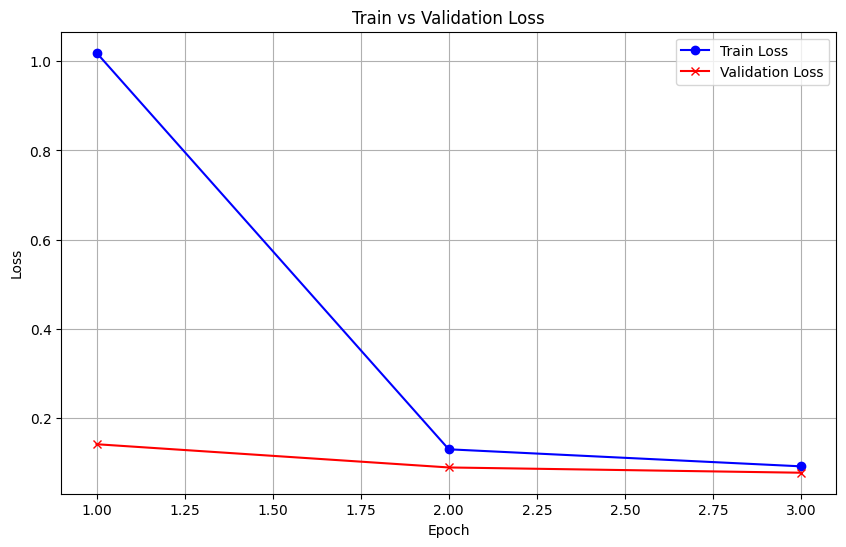

In [58]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
num_epochs = 3

if not skip_training:
    epoch_train_losses = []
    epoch_validation_losses = []
    for epoch in range(num_epochs):
        model = model.to(device)
        model.train()  # Set model to training mode
        total_loss = 0
        num_samples = 0
        for src_batch, tgt_batch in train_loader:
            optimizer.zero_grad()
            # set input source as src_batch
            # set input target as start of target sentence untill -1 (i.e. discard the last token) (past) [name it as tgt_input]
            # set expexted target as target sentence from 1 to the end (i.e. discard the first token) (future) [name it as tgt_expected]
            # use input source and input target (tgt_input) as input to the model
            # expexted target will be used in loss to compare it with the model output.
            # Remember to use padding and target causal masks on the model call:
            # get padding mask of source,
            # get padding mask of input target, convert it to float (.float()),
            # get tgt_mask of input target,
            # pass inout source, input target, source padding mask, and tgt_mask to the model to get the predictions (output).

            # YOUR CODE HERE
            src_input = src_batch
            tgt_input = tgt_batch[:, :-1]
            tgt_expected = tgt_batch[:, 1:]

            src_padding_mask = model.create_pad_mask(src_input)
            tgt_padding_mask = model.create_pad_mask(tgt_input).float()
            tgt_mask = model.get_tgt_mask(tgt_input)

            _, output = model(src_input, tgt_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_mask=tgt_mask)

            output = output.to(device)
            output = output.contiguous().view(-1, vsize_tgt)
            tgt_expected = tgt_expected.contiguous().view(-1)

            loss = criterion(output, tgt_expected)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_samples += src_batch.shape[0]

        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_loss = round(epoch_train_loss, 4)
        epoch_train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss}")

        ################################################################

        model.eval()
        validation_loss = 0
        num_samples = 0
        with torch.no_grad():
            for src_batch, tgt_batch in val_loader:
                # set input source as src_batch
                # set input target as start of target sentence untill -1 (i.e. discard the last token) (past) [name it as tgt_input]
                # set expexted target as target sentence from 1 to the end (i.e. discard the first token) (future) [name it as tgt_expected]
                # use input source and input target (tgt_input) as input to the model
                # expexted target will be used in loss to compare it with the model output.
                # Remember to use padding and target causal masks on the model call:
                # get padding mask of source,
                # get padding mask of input target, convert it to float (.float()),
                # get tgt_mask of input target,
                # pass inout source, input target, source padding mask, and tgt_mask to the model to get the predictions (output).

                # YOUR CODE HERE
                src_input = src_batch
                tgt_input = tgt_batch[:, :-1]
                tgt_expected = tgt_batch[:, 1:]

                src_padding_mask = model.create_pad_mask(src_input)
                tgt_padding_mask = model.create_pad_mask(tgt_input).float()
                tgt_mask = model.get_tgt_mask(tgt_input)

                _, output = model(src_input, tgt_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_mask=tgt_mask)

                output = output.to(device)
                output = output.contiguous().view(-1, vsize_tgt)
                tgt_expected = tgt_expected.contiguous().view(-1)
                loss = criterion(output, tgt_expected)
                validation_loss += loss.item()
                num_samples += src_batch.shape[0]

            epoch_validation_loss = validation_loss / len(val_loader)
            epoch_validation_loss = round(epoch_validation_loss, 4)
            epoch_validation_losses.append(epoch_validation_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {epoch_validation_loss}")
        torch.save(model.state_dict(), 'model.pth')

    print("Training completed.")
    torch.save(model.state_dict(), 'model.pth')

    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, epoch_train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, epoch_validation_losses, label='Validation Loss', color='red', marker='x')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [59]:
#Visible test
all_tests_successful = True
# Tests for checking the performance of the trained model
# Test if the train and validation losses are within the correct range
if not skip_training:
    try:
        if not (epoch_train_loss <= 0.1):
            raise AssertionError(
                f"Task:3: Visible test: Training loss {epoch_train_loss} must be smaller than 0.1"
            )
    except AssertionError as e:
        all_tests_successful = False
        feedback_txt.append(str(e))
        print(e)

    try:
        if not (epoch_validation_loss <= 0.1):
            raise AssertionError(
                f"Task:3: Visible test: Validation loss {epoch_validation_loss} must be smaller than 0.1"
            )
    except AssertionError as e:
        all_tests_successful = False
        feedback_txt.append(str(e))  #
        print(e)

    # Final message
    if all_tests_successful:
        success_str = "Good job! The final train loss and validation loss are in the expected range!"
        print(f"\033[92m{success_str}\033[0m")
    else:
        raise AssertionError("Training/validation performance check failed.")



Good job! The final train loss and validation loss are in the expected range!


In [60]:
# Do not delete this cell

## Task 4: Autoregressive Translation (5 points)

Finally, we are going to use the trained model to perform an actual translation task, translating French sentences into English. Exciting!

The inference works in an autoregressive manner. This means that, during the translation process, the model generates each token in the target sequence one at a time, using the previously generated token as input for predicting the next one. At each step, the model uses the encoded source sentence along with the target sequence generated so far to predict the next word. This approach allows the model to produce the translation step by step, instead of generating the entire sequence at once.

The steps for translation are as follows:

**Source Sentence Encoding:** First, we obtain the source sequence embedding and pass it through the encoder to obtain its encoded representation.

**Initializing Target Sentence with <SOS> Token:** We initialize the target sentence with the special <SOS> (Start Of Sentence) token, which indicates the beginning of the translation.

**Autoregressive Loop to Translate Target Tokens One at a Time:** We enter a loop where the model predicts the next token in the sequence based on the previously generated token and the encoded source sentence. This loop continues until the model predicts the <EOS> (End Of Sentence) token or the maximum sequence length is reached.

In the cell below, fill in the blanks as instructed to create the translation loop for the provided example sentences. Once you have completed the template, run it and observe the printed translation results.

Remeber to submit **'translation.npy'** to Moodle along with your other files.

In [61]:
seq_len=10
start_token=1
end_token=2
model.eval()

# Convert src_sentence to tokenized integers in the vocabulary dictionary
example_source_sentences = ["new jersey est parfois calme pendant l' automne.", "california est généralement calme en mars."]
example_tokenized = tokenize(example_source_sentences)
src_sentences = []
for ex in example_tokenized:
    ex_inds = []
    for t in ex:
        t_ind = fr_word2idx [t]
        ex_inds.append(t_ind)
    src_sentences.append(ex_inds)

translated_sequences = []
for counter, src_sentence in enumerate(src_sentences):
    # Convert source tokens to Tensor
    src_tensor = torch.tensor(src_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, src_seq_length)

    # 1. create src_padding_mask
    # 2. get "memory" by passing source with create src_padding_mask through encode block (model.encode)

    # YOUR CODE HERE
    src_padding_mask = model.create_pad_mask(src_tensor)
    memory = model.encode(src_tensor, src_padding_mask)

    # initialize the predicted tgt_tokens (translation) with start token
    tgt_tokens = torch.ones(1, 1).fill_(start_token).type(torch.long).to(device) #(1,1)

    for i in range(seq_len-1):
        # 1. Mask out the unpredicted tokens in the target (i.e., get tgt_mask)
        # 2. get output by passing target (the generated part up to current `i`) and memory to decode block (model.decode)
        # 3. remember to pass also tgt_mask
        # 4. get a probability vector by passing output through linear layer (projection to vocabulary size)
        # 5. use "torch.max" to get the index of the predicted word
        # 6. Convert it to a tensor on device (name it as "next_tgt_item")
        # 7. add "next_tgt_item" to tgt_tokens (use torch.cat)
        # 8. Stop (break) if "end_token" is generated

        # YOUR CODE HERE
        tgt_mask = model.get_tgt_mask(tgt_tokens)
        tgt_padding_mask = model.create_pad_mask(tgt_tokens).float()
        decoded = model.decode(tgt_tokens, memory, tgt_mask, tgt_padding_mask)
        logits = model.fc_out(decoded)
        next_token_logits = logits[-1, 0, :]
        _, next_idx = torch.max(next_token_logits, dim=-1)
        next_tgt_item = next_idx.view(1, 1).to(device)
        tgt_tokens = torch.cat([tgt_tokens, next_tgt_item], dim=1)
        if next_idx.item() == end_token:
          break

    translated_tokens = tgt_tokens.squeeze().tolist()
    translated_sentence = ' '.join ([en_idx2word[i] for i in translated_tokens[1:]])
    translated_sequences.append(translated_tokens)
    print("original_sentence:", example_source_sentences[counter])
    print("translated_sentence:", translated_sentence)
    print(10*'-')

np.save('translation.npy', np.array(translated_sequences, dtype=object))

original_sentence: new jersey est parfois calme pendant l' automne.
translated_sentence: china <EOS>
----------
original_sentence: california est généralement calme en mars.
translated_sentence: china <EOS>
----------


In [62]:
# Do not delete this cell

In [63]:
# Do not delete this cell
